In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
data = sm.datasets.co2.load_pandas()
y = data.data


## Pre-Process Data

1. make the conversion with the resample function. Resample weekly data to monthly by taking the mean of all the values in it. http://benalexkeen.com/resampling-time-series-data-with-pandas/

2. use the fillna() function to ensure that we have no missing values in our time series.
3. bfill() - use NEXT valid observation to fill gap

In [16]:
y = y['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(method= 'bfill')

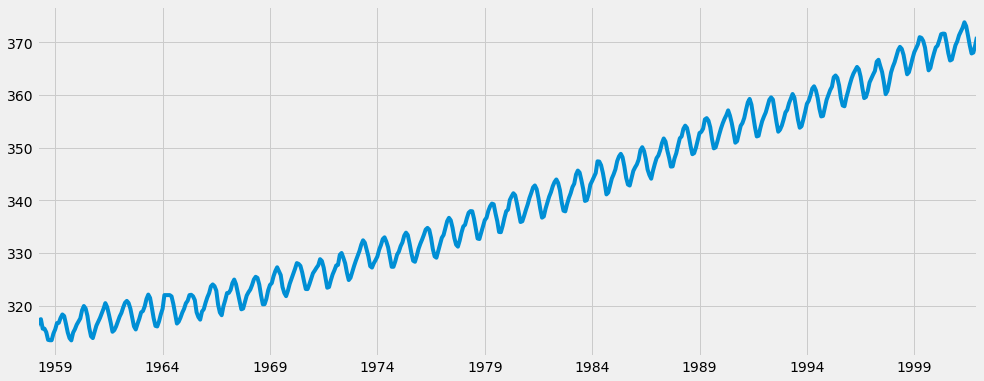

In [18]:
y.plot(figsize=(15, 6))
plt.show()

Note-
* Seasonality pattern
* Increasing trend

## The ARIMA Time Series Model
stands for Auto Regressive Integrated Moving Average.
There are three distinct integers $(p, d, q)$ that are used to parametrize ARIMA models. Together these three parameters account for seasonality, trend, and noise in datasets:
- p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

**Seasonal ARIMA**, *ARIMA(p,d,q)(P,D,Q)*. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. 

**Tuning Parameters**
We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


*Metric*-  AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624045498
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641307
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878500246952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912894922
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755126321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327375734
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067330986
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471690003
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1082.2618354804601
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.431571168119
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988165787
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194062
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385490535475
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283760499742
A

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.



## Fitting an ARIMA Time Series Model
Analyse the particular model in depth

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model. We don't reject the null hypothesis and all the features have an importance

### Model Diagonistics 
When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

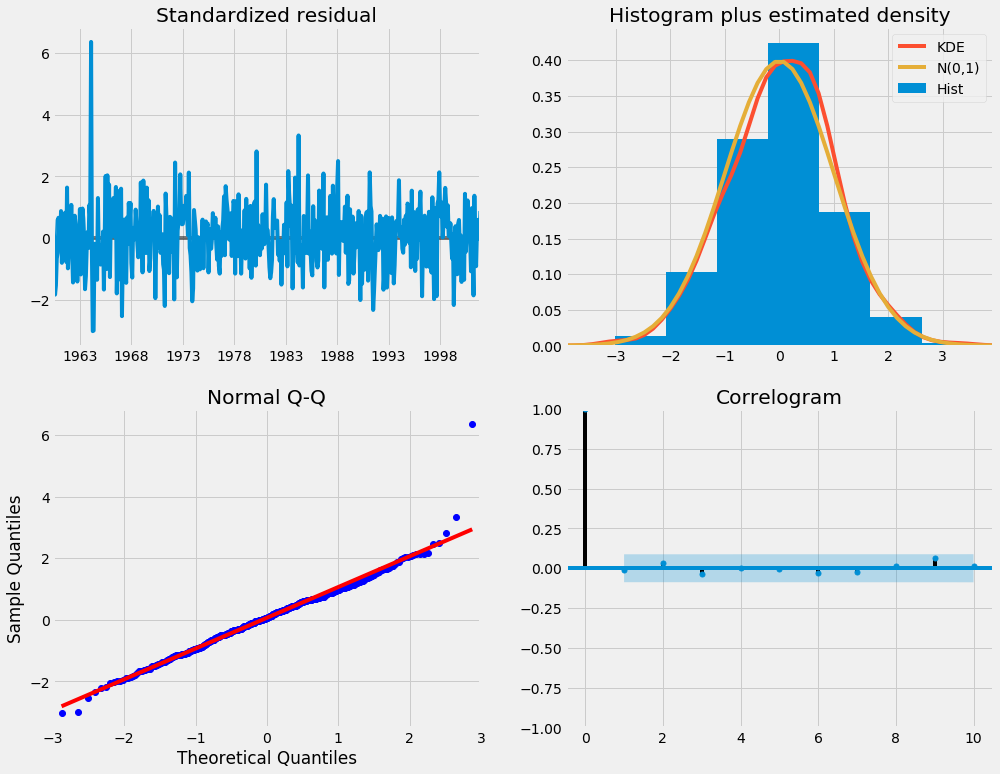

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved. Model follows a normal distribution -
hat the model residuals are normally distributed based on the following:

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Validating Forecasts
We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.



In [26]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

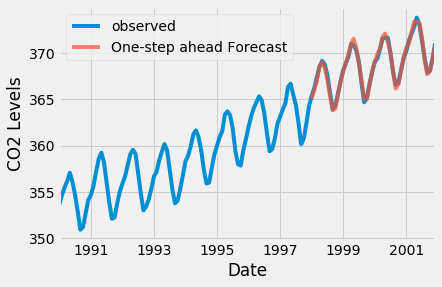

In [31]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [32]:
#Accuracy of forecast - MSE
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


**Dynamic forecasts** In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [33]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

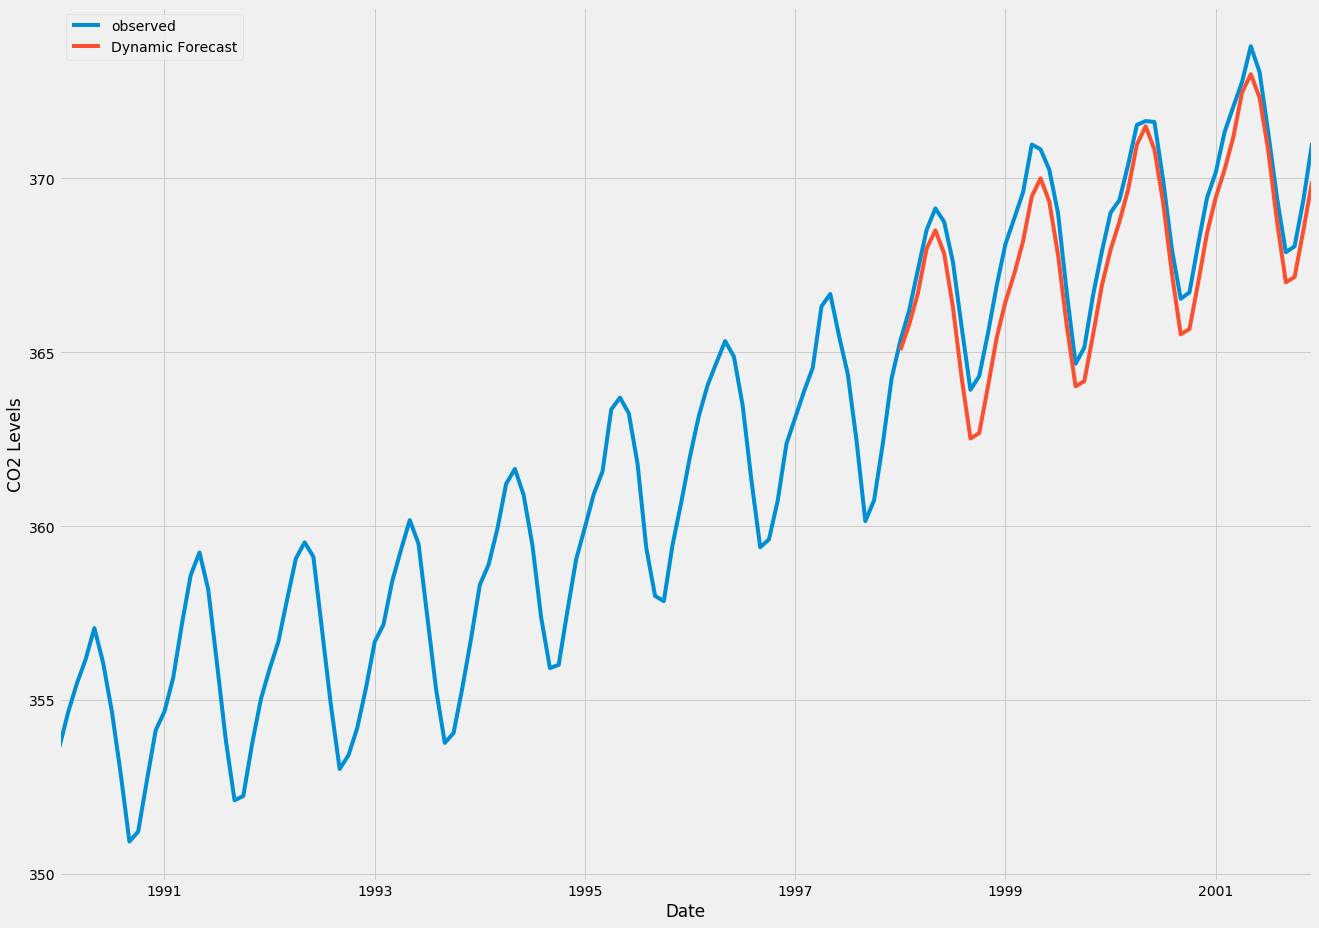

In [34]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [35]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


## Producing and Visualizing Forecasts
How to leverage our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.